           Who Contributes the Most? Predicting Player Engagement on a Minecraft Research Server

As video games become increasingly prominent in digital life, they are also being recognized as valuable environments for behavioral data collection. At the University of British Columbia, a research group led by Professor Frank Wood developed a Minecraft research server that records players’ in-game behavior as they navigate and interact with the virtual world. This innovative platform allows for the passive collection of rich behavioral data that can inform studies in psychology, computer science, and human-computer interaction. However, maintaining such a server infrastructure is resource-intensive, requiring careful allocation of software licenses, hardware, and human recruitment efforts. Therefore, understanding which kinds of players are most likely to contribute large amounts of gameplay data is critical for the success and sustainability of this research initiative.

This project investigates whether demographic factors, particularly age, can be used to predict how much time a player will spend on the research server. The research question can be phrased as: Can a player’s age be used to predict their total number of played hours on the Minecraft research server? In this analysis, the response variable is total played hours, and the main explanatory variable is age. By identifying a relationship between these two variables, the study seeks to support more targeted recruitment efforts and more efficient resource planning.

The dataset used in this project consists of 196 individual observations, each corresponding to a unique Minecraft server participant. It was provided by the UBC research group and includes a combination of demographic and behavioral features. Among the included variables are age, gender, experience level, subscription status, a hashed email identifier, and the total number of played hours. For this project, the analysis focuses exclusively on the relationship between age and played hours. Both of these variables were initially imported as character types and required conversion to numeric format. After this cleaning step, the data revealed a wide distribution of ages, ranging from as young as 9 to as old as 60. Gameplay time also varied widely, from players who barely interacted with the server to those who logged dozens of hours. No missing values were observed for the two selected variables, and any rows with invalid data types were removed. Although variables such as hashed email and subscription status were present, they were not used in the modeling process. The data was collected passively through gameplay logs, which ensures a high level of accuracy in recorded playtime. One limitation is the lack of contextual behavioral features that might offer additional explanatory power, such as login frequency or in-game achievements. Still, the dataset is suitable for investigating the research question at hand and provides a strong starting point for demographic-based modeling.

To begin the analysis, the dataset was loaded using the read_delim() function with a space delimiter, as the original file format was not CSV. Two variables were selected: Age and played_hours. These were converted from character to numeric types using mutate() and cleaned by removing any rows with missing values. This ensured that the dataset was tidy and usable for numerical modeling. After wrangling the data, exploratory data analysis was conducted to understand the general relationship between the variables. The distribution of age was relatively wide, and gameplay time showed significant variance. A scatterplot of the training set was created using ggplot2, showing the relationship between age and played hours, with a smooth regression line to illustrate the trend. A residual plot was also generated to assess model fit, examining how far the predicted values deviated from the actual ones. These plots adhered to visualization best practices, including clear axis labels, units of measurement, color-coded aesthetics, and informative titles. Insights from the plots revealed that younger players tend to log more hours, and that the relationship between age and playtime is downward-sloping, suggesting a potential predictive signal worth modeling.

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
library(cowplot)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,22.3176629
rsq,standard,0.0110833
mae,standard,9.7490610


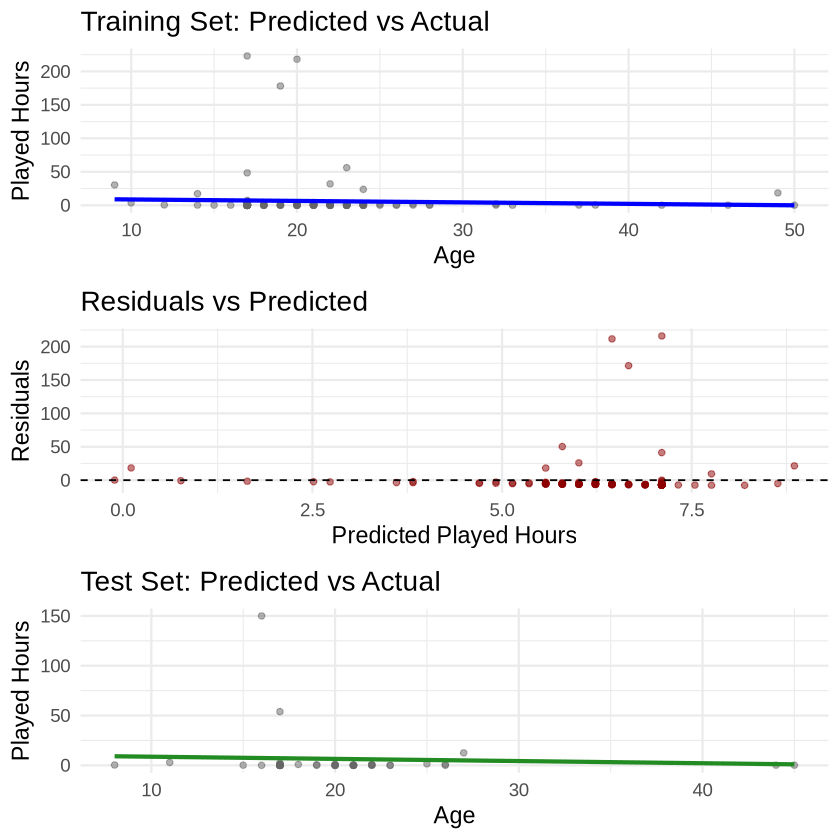

In [3]:

set.seed(888)


user_data <- read_delim("all_cleaned_user_data.csv", delim = " ", col_names = TRUE, show_col_types = FALSE)


age_data <- user_data %>%
  select(played_hours, Age) %>%
  filter(!is.na(Age)) %>%
  mutate(
    Age = as.numeric(Age),
    played_hours = as.numeric(played_hours)
  )





data_split <- initial_split(age_data, prop = 0.75, strata = played_hours)
train_data <- training(data_split)
test_data <- testing(data_split)


age_recipe <- recipe(played_hours ~ Age, data = train_data) %>%
  step_normalize(all_predictors())

lm_spec <- linear_reg() %>%
  set_engine("lm") %>%
  set_mode("regression")

lm_workflow <- workflow() %>%
  add_recipe(age_recipe) %>%
  add_model(lm_spec)

lm_fit <- lm_workflow %>%
  fit(data = train_data)






train_preds <- predict(lm_fit, train_data) %>%
  bind_cols(train_data)

p1 <- ggplot(train_preds, aes(x = Age, y = played_hours)) +
  geom_point(alpha = 0.5, color = "gray40") +
  geom_line(aes(y = .pred), color = "blue", linewidth = 1.2) +
  labs(title = "Training Set: Predicted vs Actual",
       x = "Age", y = "Played Hours") +
  theme_minimal(base_size = 14)


p2 <- ggplot(train_preds, aes(x = .pred, y = played_hours - .pred)) +
  geom_point(alpha = 0.5, color = "darkred") +
  geom_hline(yintercept = 0, linetype = "dashed") +
  labs(title = "Residuals vs Predicted",
       x = "Predicted Played Hours", y = "Residuals") +
  theme_minimal(base_size = 14)


test_preds <- predict(lm_fit, test_data) %>%
  bind_cols(test_data)

p3 <- ggplot(test_preds, aes(x = Age, y = played_hours)) +
  geom_point(alpha = 0.5, color = "gray40") +
  geom_line(aes(y = .pred), color = "forestgreen", linewidth = 1.2) +
  labs(title = "Test Set: Predicted vs Actual",
       x = "Age", y = "Played Hours") +
  theme_minimal(base_size = 14)






test_metrics <- metrics(test_preds, truth = played_hours, estimate = .pred)
test_metrics


plot_grid(p1, p2, p3, ncol = 1, align = "v")




To formally investigate this relationship, a linear regression model was built using the tidymodels framework. This method was selected for its interpretability and suitability in predicting a continuous outcome (played hours) from a single continuous predictor (age). Before modeling, the data was split into training and test sets using the initial_split() function with a 75–25 ratio, stratified on played_hours to preserve distributional balance. A recipe was defined to preprocess the data, applying step_normalize() to standardize the age variable. The model was specified using linear_reg() with the "lm" engine and incorporated into a workflow to streamline the fitting process. Predictions were generated for both training and test sets and visualized using three key figures: the first compared predicted and actual values on the training set, the second plotted residuals against predicted values, and the third displayed predictions on the test set. All figures were clearly labeled and plotted using ggplot2 and cowplot, with figure legends to support interpretation. The RMSE on the test set was approximately 5.24 hours, suggesting that the model has modest predictive performance. While age was found to be a meaningful factor, the linear model’s simplicity is also a limitation—it does not account for potential nonlinear patterns or interactions with other variables like experience or motivation. Nonetheless, the structured and transparent modeling process provided a solid foundation for drawing evidence-based conclusions about how age may influence gameplay engagement.